# Import libraries

In [1]:
import calendar
import numpy as np 
import pandas as pd
from statsmodels.tsa.arima_process import arma_generate_sample
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

# Options

In [2]:
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.grid'] = True
warnings.filterwarnings("ignore")

# Set variables

In [3]:
n_timepoints = 12 # number of timepoints
n_features = 50 # number of features (i.e. columns of X) for each timepoints
n_observations = 5_000 # number of observations (i.e. rows of y) for each timepoint
timepoints = np.arange(n_timepoints)

In [4]:
x_history = {} # dictionary {timepoint: X_timepoint}
y_history = {} # dictionary {timepoint: y_timepoint}
beta_history = {} # dictionary {timepoint: beta_timepoint}

In [5]:
approaches = {} # dictionary {approach_name: approach_description}

# the approach description has the following format:
# 
# approaches[approach_name] = {set_name: list_of_data_subsets}, where:
#    list_of_data_subsets = [lag_of_data_subset_with_respect_to_current_date, rel_index_from, rel_index_to], where:
#       lag_of_data_subset_with_respect_to_current_date: e.g. -1 means current_timepoint -1
#       rel_index_from, rel_index_to: relative indexes of rows of a np.ndarray: e.g. .3 means index .3 * len(np.ndarray)
#
# for instance: approaches['in time'] = {'train': [[-1, 0, .6]]} means for approach named 'in time', for training data, take data at 
# lag -1 from relative index 0 to relative index .6 (which means the first 60% of rows)

approaches['In-Time'] = {
    'train':      [[- 1,  0, .6]],
    'validation': [[- 1, .6, .8]],
    'test':       [[- 1, .8,  1]],
    'future':     [[  0,  0,  1]]
}

approaches['Walk-Forward'] = {
    'train':      [[- 2,  0,  1]],
    'validation': [[- 1,  0, .5]],
    'test':       [[- 1, .5,  1]],
    'future':     [[  0,  0,  1]]
}

approaches['Walk-Backward'] = {
    'train':      [[- 1,  0,  1]],
    'validation': [[- 3,  0,  1]],
    'test':       [[- 2,  0,  1]],
    'future':     [[  0,  0,  1]]
}

timepoint_from = - min(min([min([lag[0][0] for lag in approach_description.values()]) for approach_description in approaches.values()]), 0)
timepoint_to = n_timepoints - max(max([max([lag[0][0] for lag in approach_description.values()]) for approach_description in approaches.values()]), 0)

In [6]:
setnames = ['train', 'validation', 'test', 'future']

summary = pd.DataFrame(
    index = approaches.keys(), 
    columns = setnames + ['abs(test - future)'], 
    dtype = float
)

metric = 'mae' # supported: ['mae', 'mse']

# Generate data

## X (matrix of features) for each time point

$X_t \sim N(0, I) \; \; \; \forall t = 1, 2, ..., 12$

In [7]:
for timepoint in timepoints:
    np.random.seed(timepoint)
    x_history[timepoint] = np.random.normal(size = (n_observations, n_features))

## Beta (array of parameters) for each time point

$\beta^{(i)} \rightarrow ARMA(1,1) \; \; \; \forall i = 1, 2, ..., 50$

In [8]:
beta_history_array = np.zeros(shape = (n_timepoints, n_features))

for feature in range(n_features):
    np.random.seed(feature); baseline = np.random.uniform(-3, 3)
    np.random.seed(feature); arma = arma_generate_sample(ar = [1, -.3], ma = [1, .3], scale = .5, nsample = n_timepoints)
    beta_history_array[:, feature] = baseline + arma

beta_history = dict(zip(timepoints, beta_history_array))

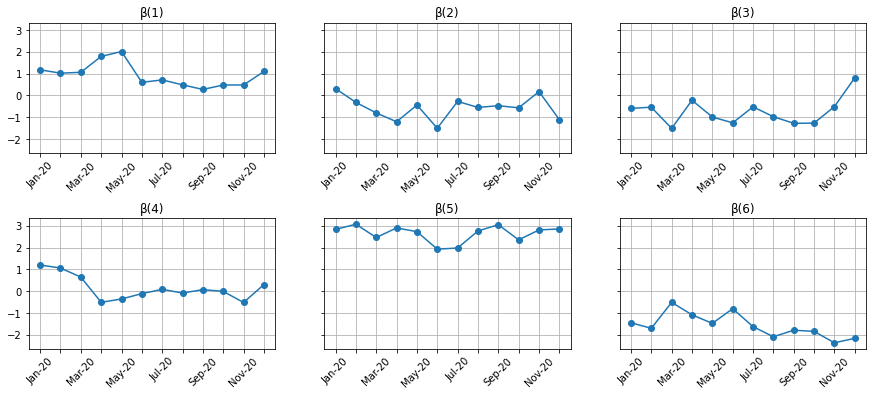

In [9]:
n_rows_plot = 2
n_columns_plot = 3

fig, axs = plt.subplots(
    n_rows_plot, 
    n_columns_plot,
    sharey = True,
    figsize = (n_columns_plot * 5, n_rows_plot * 3))
fig.subplots_adjust(hspace = .5)

for beta_ix in range(n_rows_plot * n_columns_plot):
    row_ix, col_ix = beta_ix // n_columns_plot, beta_ix % n_columns_plot
    axs[row_ix, col_ix].plot(timepoints[:12], beta_history_array[:12, beta_ix], marker = 'o')
    axs[row_ix, col_ix].set(
        title = 'β({})'.format(beta_ix + 1),
        xticks = range(0,12,1)
        )
    axs[row_ix, col_ix].set_xticklabels(
        labels = ['Jan-20', '', 'Mar-20', '', 'May-20', '', 'Jul-20', '', 'Sep-20', '', 'Nov-20', ''],
        rotation = 45)
    
fig.savefig('arma.png', dpi = 300)

## y (target variable)

$y_{t+1} = 
\beta^{(1)}_{t+1} x^{(1)}_t + 
\beta^{(2)}_{t+1} x^{(2)}_t + ... + 
\beta^{(50)}_{t+1} x^{(50)}_t + \epsilon_{t+1}$

In [10]:
for timepoint in timepoints:
    x, beta = x_history[timepoint], beta_history[timepoint]
    np.random.seed(timepoint); error = np.random.normal(scale = .5, size = n_observations)
    y_history[timepoint] = np.sum(x * beta, axis = 1) + error

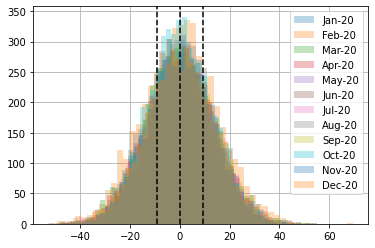

In [11]:
y_values = np.array(list(y_history.values())).flatten()
quantiles = np.quantile(y_values, np.arange(.25, 1, .25))

for i in range(len(y_history)):
    plt.hist(y_history[i], alpha = .3, bins = 50, label = calendar.month_name[i+1][:3] + '-20')
    
[plt.axvline(x = quantile, linestyle = '--', color = 'black') for quantile in quantiles]

plt.legend()

plt.savefig('y.png', dpi = 300);

# Try approaches

In [12]:
def yield_data(approach):
    """
    Yield data relative to a given approach.

    Parameters
    ----------
    approach : dict = {string: list}
        Description of a temporal approach for choosing train, validation and test data.
        Format is {setname: data_description} where:
            data_description = [lag_of_data_subset_with_respect_to_current_date, rel_index_from, rel_index_to], where:
                lag_of_data_subset_with_respect_to_current_date: e.g. -1 means current_timepoint -1
                rel_index_from, rel_index_to: relative indexes of rows of a np.ndarray: e.g. .3 means index .3 * len(np.ndarray)
        Example: {'train': [[- 1,  0, .8]], 'validation': [[- 2, .8,  1]]} means
            take the first 80% of rows of data at lag -1 for 'train', and the last 20% of data at lag -2 for 'validation'  
        

    Returns
    -------
    x : dict = {string: np.ndarray}
        Dictionary containing arrays of features (independent variable).
        Format is {setname: x_set}, e.g. {'train': np.random.normal(size = (nobs, nfeat)), 'validation': np.random.normal(size = (nobs, nfeat))}.
    y : dict = {string: np.array}
        Dictionary containing arrays of target (dependent variable).
        Format is {setname: y_set}, e.g. {'train': np.random.normal(size = nobs), 'validation': np.random.normal(size = nobs)}.
    """
    
    for timepoint_current in range(timepoint_from, timepoint_to):
        
        x, y = {}, {}
        
        for setname in setnames:
            
            x[setname], y[setname] = np.empty(shape = (0, n_features)), np.empty(shape = (0))
            
            for lag, rel_ix_from, rel_ix_to in approach[setname]:
                timepoint_lag = timepoint_current + lag
                x_lag, y_lag = x_history[timepoint_lag], y_history[timepoint_lag]
                ix_from, ix_to = (np.array([rel_ix_from, rel_ix_to]) * len(x_lag)).astype(int)
                x_lag, y_lag = x_lag[ix_from : ix_to, :], y_lag[ix_from : ix_to]
                x[setname] = np.vstack([x[setname], x_lag]) 
                y[setname] = np.append(y[setname], y_lag)
                                    
        yield x, y

In [13]:
def model_fit_evaluate(x, y):
    """
    Fit model (CatBoostRegressor) on data and return a performance metric.

    Parameters
    ----------
    x : dict = {string: np.ndarray}
        Dictionary containing arrays of features (independent variable).
        Format is {setname: x_set}, e.g. {'train': np.random.normal(size = (nobs, nfeat)), 'validation': np.random.normal(size = (nobs, nfeat))}.
    y : dict = {string: np.array}
        Dictionary containing arrays of target (dependent variable).
        Format is {setname: y_set}, e.g. {'train': np.random.normal(size = nobs), 'validation': np.random.normal(size = nobs)}.

    Returns
    -------
    output_metric: dict = {string: float}
        Dictionary containing performance metric for each set.
        Format is {setname: set_performance}, e.g. {'train': 8.37, 'validation': 9.42}.
    """
        
    model = CatBoostRegressor().fit(
        X = x['train'], y = y['train'],
        eval_set = (x['validation'], y['validation']),
        early_stopping_rounds = 5, use_best_model = True,
        silent = True
    )
    
    output_metric = pd.Series(index = x.keys(), dtype = float)
    
    for setname in output_metric.index:
        pred = model.predict(x[setname])
        if metric == 'mse':
            output_metric[setname] = mean_squared_error(y[setname], pred)
        if metric == 'mae':
            output_metric[setname] = mean_absolute_error(y[setname], pred)
        
    return output_metric

In [14]:
%%time

for approach_name, approach in tqdm(approaches.items()):
    
    approach_metric = pd.DataFrame(columns = setnames, dtype = float)
    
    for timepoint, (x, y) in enumerate(yield_data(approach)):
        timepoint_metric = model_fit_evaluate(x, y)
        approach_metric.loc[timepoint, setnames] = timepoint_metric[setnames]
        approach_metric.loc[timepoint, 'abs(test - future)'] = abs(timepoint_metric['test'] - timepoint_metric['future'])
        
    summary.loc[approach_name, :] = approach_metric.mean()

100%|██████████| 3/3 [01:34<00:00, 31.64s/it]

CPU times: user 46min 40s, sys: 33.5 s, total: 47min 14s
Wall time: 1min 34s


In [15]:
summary_out = summary[['test', 'future', 'abs(test - future)']].round(2)

In [16]:
summary_out.columns = [colname.replace('test', 'MAE(test)').replace('future', 'MAE(future)') for colname in summary_out.columns]

summary_out

,MAE(test),MAE(future),abs(MAE(test) - MAE(future))
In-Time,2.91,4.20,1.29
Walk-Forward,3.82,4.51,0.76
Walk-Backward,4.00,3.98,0.43
